# LAPD 'homeless' crimes: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# data exported from '00-lapd-crimes-processing.ipynb'
src = pd.read_feather('/Users/mhustiles/data/data/LA/crimes.feather')

In [3]:
src.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
0,4,100100501,2010-01-03,2010-01-02,2100,1,Central,176,1,122,"Rape, attempted",0400,47,female,H,103,Alley,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday,January,hispanic,21,00,pt_one_violent
1,5,100100506,2010-01-05,2010-01-04,1650,1,Central,162,1,442,Shoplifting - petty theft ($950 & under),0344 1402,23,male,B,404,Department store,nan,None,AA,adult_arrest,442,nan,nan,nan,700 W 7TH ST,None,34.0480,-118.2577,2010,1,4,1,Monday,January,black,16,50,pt_one_property
2,6,100100508,2010-01-08,2010-01-07,2005,1,Central,182,1,330,Burglary from vehicle,0344,46,male,H,101,Street,nan,None,IC,invest_cont,330,nan,nan,nan,PICO BL,GRAND AV,34.0389,-118.2643,2010,1,7,1,Thursday,January,hispanic,20,05,pt_one_property
3,7,100100509,2010-01-09,2010-01-08,2100,1,Central,157,1,230,"Assault with deadly weapon, aggravated assault",0416,51,male,B,710,Other premise,500.0,Unknown weapon/other weapon,AA,adult_arrest,230,nan,nan,nan,500 CROCKER ST,None,34.0435,-118.2427,2010,1,8,1,Friday,January,black,21,00,pt_one_violent
4,8,100100510,2010-01-09,2010-01-09,0230,1,Central,171,1,230,"Assault with deadly weapon, aggravated assault",0400 0416,30,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,230,nan,nan,nan,800 W OLYMPIC BL,None,34.0450,-118.2640,2010,1,9,1,Saturday,January,hispanic,02,30,pt_one_violent


---

## Limit dataframe to serious crimes — the type reported to FBI

In [4]:
crimes = src[src['part_type'] == '1']

### Cases involving suspects or victimes defined by LAPD as 'homeless'

In [5]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [6]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes.head()

,mo_code,mo_code_description
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


In [7]:
# Chief Beck orders departmentwide focus on coding in 2016
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


### Limit homeless crime data to recent years to account for coding issues

In [8]:
homeless_dates = ['2018', '2019']

### Various filters

In [9]:
#Homeless people codes
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('Criminal homicide', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [10]:
homeless_victims_women = homeless_victims[homeless_victims['victim_sex'] == 'female']

### How many cases do we have involving homeless people? 

In [11]:
len(homeless_victims_women)

2146

In [12]:
len(homeless_victims)

6010

In [13]:
len(homeless_suspects)

9602

In [14]:
homeless_victims.columns

Index(['index', 'record_id', 'date_reported', 'date_occurred', 'time_occurred',
       'division', 'division_name', 'reporting_district', 'part_type',
       'crime_code', 'crime_code_description', 'modus_operandi_code',
       'victim_age', 'victim_sex', 'victim_descent', 'premises_code',
       'premises_description', 'weapon_code', 'weapon_description',
       'status_code', 'status_code_description', 'crm_cd_1', 'crm_cd_2',
       'crm_cd_3', 'crm_cd_4', 'address', 'cross_street', 'latitude',
       'longitude', 'year', 'quarter', 'day', 'month', 'weekday', 'monthname',
       'descent_description', 'hour', 'minute', 'part_category'],
      dtype='object')

---

### Group by cases involving homeless victims

In [15]:
homeless_victims_years = homeless_victims.groupby\
(['division_name']).agg('size').reset_index(name='total')

### Group by cases involving homeless suspects

In [16]:
homeless_suspects_years = homeless_suspects.groupby\
(['division_name']).agg('size').reset_index(name='total')
homeless_suspects_years.head()

,division_name,total
0,77th Street,232
1,Central,2260
2,Devonshire,210
3,Foothill,201
4,Harbor,320


---

### Homeless homicides

In [17]:
homeless_homicides.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
915664,1668111,180600613,2018-01-23,2018-01-22,2300,6,Hollywood,647,1,110,Criminal homicide,1218 1402 0416 0449 1401 1409 2004,45,male,H,110,Freeway,308.0,Stick,AA,adult_arrest,110,998,nan,nan,VENTURA BL,SUNSET BL,34.0998,-118.3211,2018,1,22,1,Monday,January,hispanic,23,00,pt_one_violent
919717,1675075,180123968,2018-09-16,2018-09-16,0430,1,Central,152,1,110,Criminal homicide,0400 0416 1218 2004 0344,59,male,B,102,Sidewalk,304.0,Club/bat,AA,adult_arrest,110,nan,nan,nan,700 WILSHIRE BL,None,34.0487,-118.2571,2018,3,16,9,Sunday,September,black,04,30,pt_one_violent
921115,1677545,181100849,2018-11-11,2018-11-11,0335,11,Northeast,1123,1,110,Criminal homicide,1100 0430 1218 0395,40,male,W,501,Single family dwelling,104.0,Shotgun,AO,adult_other,110,nan,nan,nan,3100 GLENMANOR PL,None,34.1170,-118.2637,2018,4,11,11,Sunday,November,white,03,35,pt_one_violent
922366,1679789,180305553,2018-01-24,2018-01-24,1100,3,Southwest,399,1,110,Criminal homicide,1100 0430 0906 1218,42,male,B,152,Underpass/bridge*,106.0,Unknown firearm,IC,invest_cont,110,nan,nan,nan,42ND ST,FLOWER ST,34.0074,-118.2815,2018,1,24,1,Wednesday,January,black,11,00,pt_one_violent
922543,1680078,181113057,2018-07-06,2018-07-06,0950,11,Northeast,1181,1,110,Criminal homicide,0369 0446 0400 1218 2004 1402,50,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",AA,adult_arrest,110,998,nan,nan,1400 GLENDALE BL,None,34.0808,-118.2655,2018,3,6,7,Friday,July,hispanic,09,50,pt_one_violent


In [18]:
homeless_homicides_years = homeless_homicides.groupby\
(['year','division_name', 'premises_description','weapon_description']).agg('size').reset_index(name='total')

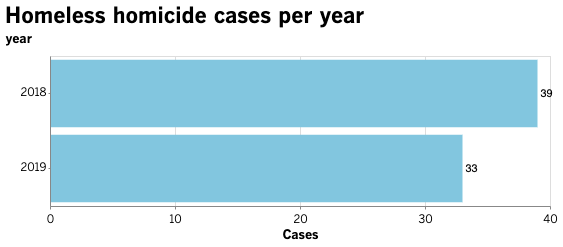

In [19]:
chart_homeless_homicides_years = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_homicides_years_text = chart_homeless_homicides_years.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)

(chart_homeless_homicides_years + chart_homeless_homicides_years_text).properties(height=150, width=500, title='Homeless homicide cases per year')

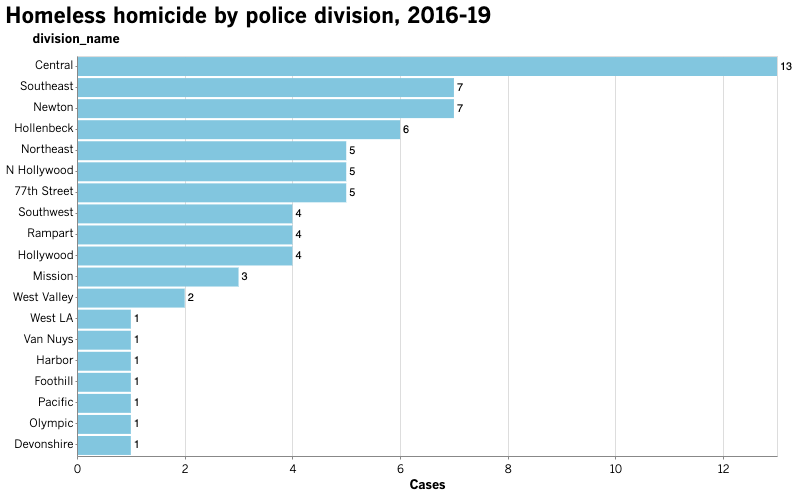

In [20]:
chart_homeless_divisions = alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('division_name:N',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_divisions_text = chart_homeless_divisions.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_divisions + chart_homeless_divisions_text)\
.properties(height=400, width=700, title='Homeless homicide by police division, 2016-19')

In [21]:
# chart_homeless_weapon = alt.Chart(homeless_homicides_years).mark_bar().encode(
#     y=alt.Y('weapon_description:N',
#         sort=alt.EncodingSortField(
#             field="total",  # The field to use for the sort
#             op="sum",  # The operation to run on the field prior to sorting
#             order="descending"  # The order to sort in
#         ), axis=alt.Axis(format='', tickCount=5)),
#     x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
# )

# chart_homeless_weapon_text = chart_homeless_weapon.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='sum(total):Q'
# )

# (chart_homeless_weapon + chart_homeless_weapon_text)\
#     .properties(height=400, width=700, title='Homeless homicide by weapon type, 2016-19')

In [22]:
# chart_homeless_location = alt.Chart(homeless_homicides_years).mark_bar().encode(
#     y=alt.Y('premises_description:N',
#         sort=alt.EncodingSortField(
#             field="total",  # The field to use for the sort
#             op="sum",  # The operation to run on the field prior to sorting
#             order="descending"  # The order to sort in
#         ), axis=alt.Axis(format='', tickCount=5)),
#     x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
# )

# chart_homeless_location_text = chart_homeless_location.mark_text(
#     align='left',
#     baseline='middle',
#     dx=3  # Nudges text to right so it doesn't appear on top of the bar
# ).encode(
#     text='sum(total):Q'
# )

# (chart_homeless_location + chart_homeless_location_text)\
# .properties(height=400, width=700, title='Homeless homicide by location type, 2017-19')

---

## Homeless victims

In [23]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head()

,year,division_name,total
22,2019,Central,1178
1,2018,Central,976
13,2018,Rampart,223
9,2018,Newton,198
30,2019,Newton,185


In [24]:
homeless_year_victim = homeless_victims.groupby(['year', 'division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_year_victim.head(10)

,year,division_name,total
22,2019,Central,1178
1,2018,Central,976
13,2018,Rampart,223
9,2018,Newton,198
30,2019,Newton,185
34,2019,Rampart,183
6,2018,Hollywood,168
12,2018,Pacific,157
27,2019,Hollywood,154
33,2019,Pacific,151


### Where do crimes involving homeless victims occur? 

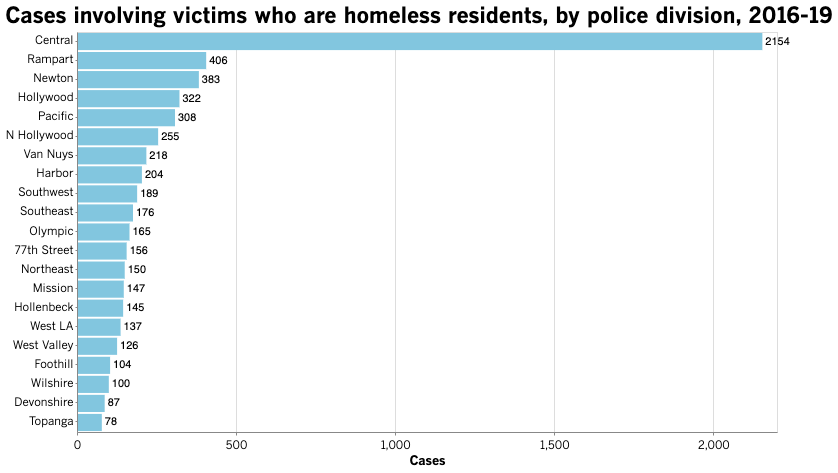

In [25]:
chart_homeless_victims = alt.Chart(homeless_victims_years).mark_bar().encode(
    y=alt.Y('division_name:N', title='',
        sort=alt.EncodingSortField(
            field="total",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(total):Q", title="Cases", axis=alt.Axis(format='', tickCount=5))
)

chart_homeless_victims_text = chart_homeless_victims.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(total):Q'
)


(chart_homeless_victims + chart_homeless_victims_text)\
.properties(height=400, width=700, title='Cases involving victims who are homeless residents, by police division, 2016-19')

In [26]:
homeless_victims['division_name'].value_counts('normalize').round(2)*100

Central        36.0
Rampart         7.0
Newton          6.0
Hollywood       5.0
Pacific         5.0
N Hollywood     4.0
Van Nuys        4.0
Harbor          3.0
Southwest       3.0
Southeast       3.0
Olympic         3.0
77th Street     3.0
Northeast       2.0
Mission         2.0
Hollenbeck      2.0
West LA         2.0
West Valley     2.0
Foothill        2.0
Wilshire        2.0
Devonshire      1.0
Topanga         1.0
Name: division_name, dtype: float64

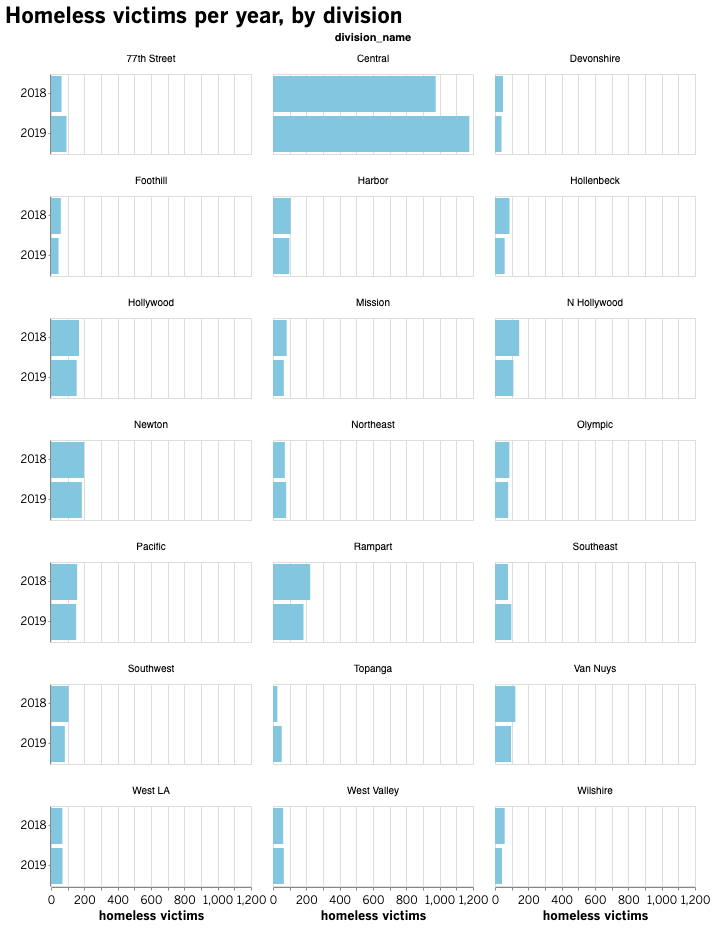

In [27]:
alt.Chart(homeless_year_victim).mark_bar().encode(
    y=alt.Y('year:N', title='', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("mean(total):Q", title="homeless victims", axis=alt.Axis(format='', tickCount=10)),
    facet='division_name:N'
).properties(height=80, width=200, columns=3, title='Homeless victims per year, by division')

### What types of crimes are most common for homeless victims?

In [28]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description','victim_sex', 'year'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
homeless_cases_victim_top = homeless_cases_victim[homeless_cases_victim['total'] > 25]

In [29]:
homeless_cases_victim.head()

,crime_code_description,victim_sex,year,total
7,"Assault with deadly weapon, aggravated assault",male,2018,828
8,"Assault with deadly weapon, aggravated assault",male,2019,822
64,Robbery,male,2018,386
65,Robbery,male,2019,348
96,Theft plain - petty ($950 & under),male,2019,314


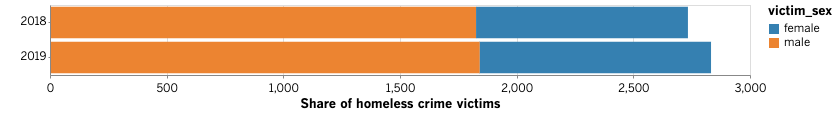

In [117]:
base_gender = alt.Chart(homeless_cases_victim_top).mark_bar().encode(
    x=alt.X('sum(total)', title='Share of homeless crime victims', axis=alt.Axis(tickCount=6)),
    y=alt.Y('year:N',title='',
            sort=alt.EncodingSortField(
            field="year:N",  # The field to use for the sort
            op="count",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in)
            )),
    color='victim_sex:N'
)

base_gender_text = base_gender.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('sum(total)', format=','), 
    color=alt.condition(
        alt.datum.year == '2018',
        alt.value('white'),
        alt.value('white')
    )
)


(base_gender + base_gender_text).properties(height=70,width=700)

### Homeless victims in central

In [31]:
homeless_victims_central = homeless_victims[homeless_victims['division_name'] == 'Central']

In [32]:
homeless_cases_victim_central = homeless_victims_central.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [33]:
homeless_cases_victim_central.head()

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",587
25,Theft plain - petty ($950 & under),524
16,Robbery,354
5,Brandish weapon,111
10,Intimate partner - aggravated assault,109


---

In [34]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [35]:
homeless_cases_suspect.head(10)

,crime_code_description,total
2,"Assault with deadly weapon, aggravated assault",2580
22,Robbery,1589
25,Shoplifting - petty theft ($950 & under),1355
6,Brandish weapon,698
33,Theft plain - petty ($950 & under),657
7,Burglary,646
16,Intimate partner - aggravated assault,464
3,Attempted robbery,300
35,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",182
8,Burglary from vehicle,177


--- 

### What are the population breakdowns for men and women?

In [36]:
homeless_female_pop_share19 = 30.1
homeless_male_pop_share19 = 67.3
homeless_male_pop19 = 24360
homeless_female_pop19 = 10845

homeless_female_pop_share19 = 31
homeless_male_pop_share19 = 67
homeless_male_pop18 = 20907
homeless_female_pop18 = 9577

city_female_pop_share = 50.5
city_male_pop_share = 45.5
city_female_pop = 2015180
city_male_pop = 1815657

### What types of crimes do female homeless residents encounter?

In [37]:
vic_sex_pivot = pd.pivot_table(homeless_cases_victim, values='total', \
                       index=['crime_code_description'],columns=['victim_sex'], \
                                        aggfunc=np.sum, fill_value=0).reset_index()

In [38]:
vic_sex_pivot['total_all'] = (vic_sex_pivot['female'] + \
                vic_sex_pivot['male'] + \
                vic_sex_pivot['unknown'])

In [39]:
vic_sex_pivot['female_share_all'] = ((vic_sex_pivot['female'] / \
                                           vic_sex_pivot['total_all'])*100).round(2)

In [40]:
vic_sex_pivot['male_share_all'] = ((vic_sex_pivot['male'] / \
                                           vic_sex_pivot['total_all'])*100).round(2)

In [41]:
vic_sex_pivot.sort_values(by='total_all', ascending=False).head(10)

victim_sex,crime_code_description,female,male,unknown,total_all,female_share_all,male_share_all
2,"Assault with deadly weapon, aggravated assault",471,1650,4,2125,22.16,77.65
19,Robbery,270,734,2,1006,26.84,72.96
30,Theft plain - petty ($950 & under),414,583,2,999,41.44,58.36
12,Intimate partner - aggravated assault,305,114,0,419,72.79,27.21
6,Brandish weapon,108,182,0,290,37.24,62.76
18,"Rape, forcible",231,4,0,235,98.30,1.70
31,"Theft, person",57,104,0,161,35.40,64.60
32,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",60,93,1,154,38.96,60.39
3,Attempted robbery,31,107,1,139,22.30,76.98
4,Bike - stolen,14,59,0,73,19.18,80.82


In [42]:
homeless_vic_sex_pivot = pd.pivot_table(homeless_cases_victim, values='total', \
                       index=['crime_code_description'],columns=['victim_sex'], \
                                        aggfunc=np.sum, fill_value=0).reset_index()

In [43]:
homeless_vic_sex_pivot['total_homeless'] = (homeless_vic_sex_pivot['female'] + \
                homeless_vic_sex_pivot['male'] + \
                homeless_vic_sex_pivot['unknown'])

In [44]:
homeless_vic_sex_pivot['female_share_homeless'] = ((homeless_vic_sex_pivot['female'] / \
                                           homeless_vic_sex_pivot['total_homeless'])*100).round(2)

In [45]:
homeless_vic_sex_pivot['male_share_homeless'] = ((homeless_vic_sex_pivot['male'] / \
                                           homeless_vic_sex_pivot['total_homeless'])*100).round(2)

In [46]:
homeless_vic_sex_pivot.sort_values(by='total_homeless', ascending=False).head(20)

victim_sex,crime_code_description,female,male,unknown,total_homeless,female_share_homeless,male_share_homeless
2,"Assault with deadly weapon, aggravated assault",471,1650,4,2125,22.16,77.65
19,Robbery,270,734,2,1006,26.84,72.96
30,Theft plain - petty ($950 & under),414,583,2,999,41.44,58.36
12,Intimate partner - aggravated assault,305,114,0,419,72.79,27.21
6,Brandish weapon,108,182,0,290,37.24,62.76
18,"Rape, forcible",231,4,0,235,98.30,1.70
31,"Theft, person",57,104,0,161,35.40,64.60
32,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",60,93,1,154,38.96,60.39
3,Attempted robbery,31,107,1,139,22.30,76.98
4,Bike - stolen,14,59,0,73,19.18,80.82


In [47]:
female_share_homeless_all = pd.merge(vic_sex_pivot, homeless_vic_sex_pivot, on='crime_code_description')

In [48]:
female_share_homeless_all_trimmed = female_share_homeless_all[[ 'crime_code_description',\
                               'total_homeless', 'female_share_all', 'female_share_homeless']]

In [49]:
female_share_homeless_all_trimmed.sort_values(by='total_homeless', ascending=False).head(20)

victim_sex,crime_code_description,total_homeless,female_share_all,female_share_homeless
2,"Assault with deadly weapon, aggravated assault",2125,22.16,22.16
19,Robbery,1006,26.84,26.84
30,Theft plain - petty ($950 & under),999,41.44,41.44
12,Intimate partner - aggravated assault,419,72.79,72.79
6,Brandish weapon,290,37.24,37.24
18,"Rape, forcible",235,98.30,98.30
31,"Theft, person",161,35.40,35.40
32,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",154,38.96,38.96
3,Attempted robbery,139,22.30,22.30
4,Bike - stolen,73,19.18,19.18


--- 

### Import homeless population by LA Times neighborhood

In [50]:
homeless_pop = \
pd.read_csv('/Users/mhustiles/data/github/notebooks/homeless-restrictions-raw/output\
/homeless-apportioned-totals-by-neighborhood.csv')

In [51]:
homeless_pop = homeless_pop[homeless_pop['totpeople'] > 1]

### Relate homeless victim/suspect incident data to LA neighborhoods, not just police geography

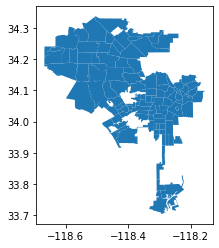

In [52]:
# Read Los Angeles Times neighborhoods
hoods = gpd.read_file('input/custom-la-hoods-skid-row.geojson')
hoods.plot()

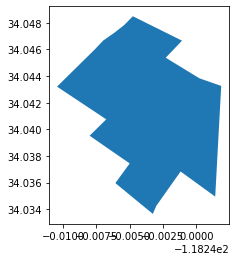

In [53]:
skidrow = hoods[hoods['name'] == 'Skid Row']
skidrow.plot()

### Convert homeless victims dataframe to geodataframe, set CRS, join with 'hoods 

In [54]:
homeless_victims_gdf = gpd.GeoDataFrame(homeless_victims, \
    geometry=gpd.points_from_xy(homeless_victims.longitude, homeless_victims.latitude))
homeless_victims_gdf.crs = ({'init':'epsg:4326'})
homeless_victims_hoods = gpd.sjoin(homeless_victims_gdf, hoods, op = 'within')

### Convert homeless suspects dataframe to geodataframe, set CRS, join with 'hoods 

In [55]:
homeless_suspects_gdf = gpd.GeoDataFrame(homeless_suspects, \
    geometry=gpd.points_from_xy(homeless_suspects.longitude, homeless_suspects.latitude))
homeless_suspects_gdf.crs = ({'init':'epsg:4326'})
homeless_suspects_hoods = gpd.sjoin(homeless_suspects_gdf, hoods, op = 'within')

### Group by hood name

In [56]:
homeless_victims_hoods_grouped = homeless_victims_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [57]:
homeless_suspects_hoods_grouped = homeless_suspects_hoods.groupby(['name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [58]:
homeless_suspects_hoods_grouped.head(10)

,name,total
22,Downtown,1525
84,Skid Row,851
45,Hollywood,506
107,Westlake,387
96,Van Nuys,378
97,Venice,370
65,North Hollywood,295
50,Koreatown,205
24,East Hollywood,190
8,Boyle Heights,157


In [59]:
homeless_victims_hoods_grouped.head(10)

,name,total
82,Skid Row,1310
19,Downtown,976
43,Hollywood,278
105,Westlake,263
95,Venice,212
94,Van Nuys,200
63,North Hollywood,140
48,Koreatown,129
21,East Hollywood,108
42,Historic South-Central,99


### Calculate crime rate among homeless victims

In [60]:
homeless_victims_hoods_merged = pd.merge(homeless_victims_hoods_grouped, homeless_pop, on='name')

In [61]:
homeless_victims_hoods_merged.sort_values(by='totpeople', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople
0,Skid Row,1310,1560.699515,1511.234336,3483.296138
1,Downtown,976,2477.656050,2298.862691,2993.002167
3,Westlake,263,1239.655588,921.219987,1755.307232
2,Hollywood,278,1191.539096,634.890246,1454.445295
9,Historic South-Central,99,944.710611,673.731808,1193.057813
15,Sun Valley,61,740.138565,245.318142,1152.144565
4,Venice,212,1091.534800,567.493195,1101.539811
10,Boyle Heights,98,869.935630,512.306282,1071.937630
5,Van Nuys,200,675.235038,327.020823,755.125837
17,Vermont Square,57,319.691371,184.630879,665.101111


In [62]:
homeless_victims_hoods_merged['rate'] = \
(homeless_victims_hoods_merged['total'] / (homeless_victims_hoods_merged['totpeople']/1000)).round(1)

In [63]:
homeless_victims_hoods_merged.sort_values(by='rate', ascending=False)

,name,total,unsheltered,unshelteredoutside,totpeople,rate
82,Toluca Lake,9,12.367069,9.539124,12.367069,727.7
105,Larchmont,2,3.229615,3.129461,3.229615,619.3
71,Lake Balboa,13,23.329680,6.488715,24.167177,537.9
100,Hollywood Hills West,3,6.521895,5.432202,6.521895,460.0
0,Skid Row,1310,1560.699515,1511.234336,3483.296138,376.1
35,Northridge,30,84.921058,23.224370,85.088915,352.6
19,North Hills,52,124.911940,72.748118,149.904106,346.9
66,Brentwood,15,20.599239,13.978384,44.658182,335.9
1,Downtown,976,2477.656050,2298.862691,2993.002167,326.1
27,Studio City,40,124.080220,99.805643,124.080220,322.4


### Calculate breaks for crime rate

In [64]:
breaks_rate \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.rate, nb_class=7)

In [65]:
breaks_rate

[14.0, 57.4, 111.3, 162.6, 239.7, 376.1, 537.9, 727.7]

In [66]:
def get_group_rate(value):
    for i, b in enumerate(breaks_rate):
        if value <= breaks_rate[i+1]:
            return i

In [67]:
homeless_victims_hoods_merged['rate_score'] = homeless_victims_hoods_merged.rate.apply(get_group_rate)

### Calculate breaks for total crimes

In [68]:
breaks_crimes \
= jenkspy.jenks_breaks(homeless_victims_hoods_merged.total, nb_class=7)

In [69]:
breaks_crimes

[1.0, 16.0, 37.0, 70.0, 140.0, 278.0, 976.0, 1310.0]

In [70]:
def get_group_crimes(value):
    for i, b in enumerate(breaks_crimes):
        if value <= breaks_crimes[i+1]:
            return i

In [71]:
homeless_victims_hoods_merged['crimes_score'] = homeless_victims_hoods_merged.total.apply(get_group_crimes)

In [72]:
homeless_victims_hoods_merged.sort_values(by='crimes_score', ascending=False).head()

,name,total,unsheltered,unshelteredoutside,totpeople,rate,rate_score,crimes_score
0,Skid Row,1310,1560.699515,1511.234336,3483.296138,376.1,4,6
1,Downtown,976,2477.656050,2298.862691,2993.002167,326.1,4,5
2,Hollywood,278,1191.539096,634.890246,1454.445295,191.1,3,4
3,Westlake,263,1239.655588,921.219987,1755.307232,149.8,2,4
4,Venice,212,1091.534800,567.493195,1101.539811,192.5,3,4


### Merge homeless victim rate by 'hoods back to the 'hoods geodataframe

In [73]:
homeless_victims_maps = hoods.merge(homeless_victims_hoods_merged, on='name', how='left')

In [74]:
homeless_victims_maps.to_file('output/homeless_victims_maps.geojson', driver='GeoJSON')

In [75]:
geojson = json.loads(homeless_victims_maps.to_json())

In [76]:
features = alt.Data(values=geojson['features'])

In [77]:
base = alt.Chart(features).mark_geoshape(
    stroke='white',
    fill='#e6e6e6',
    strokeWidth=0.1
).encode().properties(
    width=400,
    height=600
)

In [78]:
geoshape = alt.Chart(features).mark_geoshape(
    fill='#e6e6e6',
    stroke='white'
)

In [79]:
rate = geoshape.encode(
    color=alt.Color(
        "properties.rate_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
            tooltip=['properties.name:N', 'properties.rate:N'],
)

crimesall = geoshape.encode(
    color=alt.Color(
        "properties.crimes_score:N",
        scale=alt.Scale(
            domain=[0, 1, 2, 3, 4, 5, 6],
            range=lat.palette['schemes']['fire-7']
        ),
        legend=None
    ),
            tooltip=['properties.name:N', 'properties.rate:N'],
)

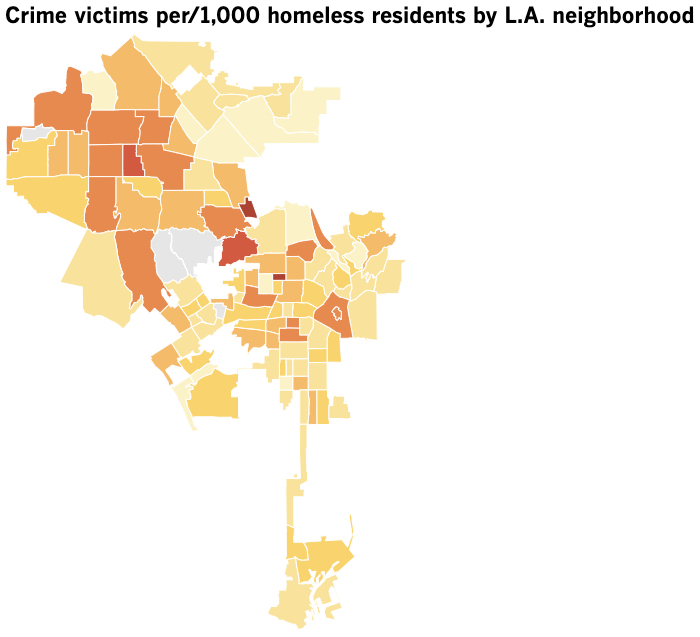

In [80]:
(base + rate).properties(title="Crime victims per/1,000 homeless residents by L.A. neighborhood").configure_view(
    strokeWidth=0
)

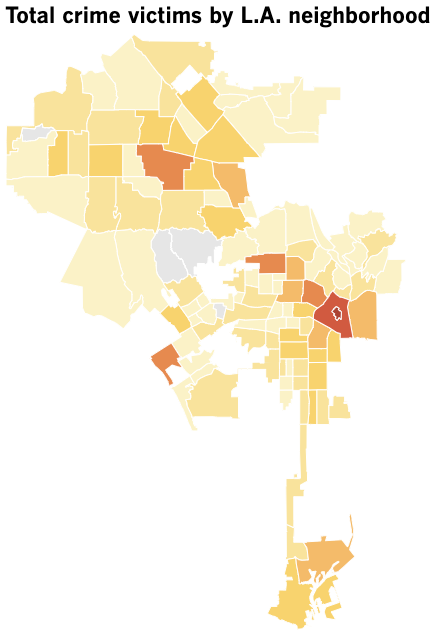

In [81]:
(base + crimesall).properties(title="Total crime victims by L.A. neighborhood").configure_view(
    strokeWidth=0
)

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [82]:
all_crimes_grouped = crimes.groupby(['crime_code_description', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [83]:
all_crimes_grouped.head(10)

,crime_code_description,victim_sex,total
26,Burglary from vehicle,male,87047
23,Burglary,male,81388
117,Theft plain - petty ($950 & under),male,76276
25,Burglary from vehicle,female,70454
7,"Assault with deadly weapon, aggravated assault",male,65349
116,Theft plain - petty ($950 & under),female,64638
22,Burglary,female,56978
78,Robbery,male,54444
132,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",male,40395
87,Shoplifting - petty theft ($950 & under),male,31950


### Which crimes are most common for homeless victims?

In [84]:
homeless_crimes_grouped = homeless_victims.groupby(['crime_code_description', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [85]:
homeless_cases_victim.head(10)

,crime_code_description,victim_sex,year,total
7,"Assault with deadly weapon, aggravated assault",male,2018,828
8,"Assault with deadly weapon, aggravated assault",male,2019,822
64,Robbery,male,2018,386
65,Robbery,male,2019,348
96,Theft plain - petty ($950 & under),male,2019,314
95,Theft plain - petty ($950 & under),male,2018,269
5,"Assault with deadly weapon, aggravated assault",female,2018,256
94,Theft plain - petty ($950 & under),female,2019,227
6,"Assault with deadly weapon, aggravated assault",female,2019,215
93,Theft plain - petty ($950 & under),female,2018,187


### Places where crimes against homeless residents occur?

In [86]:
# homeless victims
homeless_places = homeless_victims.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

# all crimes
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [87]:
homeless_places['share'] = ((homeless_places['total'] / homeless_places.total.sum())*100).round(2)

In [88]:
homeless_places.head()

,premises_description,total,share
115,Sidewalk,1846,30.72
122,Street,1594,26.52
101,Parking lot,346,5.76
89,"Multi-unit dwelling (apartment, duplex, etc)",328,5.46
100,Park/playground,210,3.49


In [89]:
places['share'] = ((places['total'] / places.total.sum())*100).round(2)

In [90]:
places.head()

,premises_description,total,share
273,Street,349886,30.64
262,Single family dwelling,143478,12.56
229,Parking lot,112576,9.86
207,"Multi-unit dwelling (apartment, duplex, etc)",83698,7.33
261,Sidewalk,60125,5.26


### Where are homeless victims cases occuring in LAPD's divisions? 

In [91]:
homeless_divisions = homeless_victims.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [92]:
homeless_divisions.head(10)

,division_name,total
1,Central,2154
13,Rampart,406
9,Newton,383
6,Hollywood,322
12,Pacific,308
8,N Hollywood,255
17,Van Nuys,218
4,Harbor,204
15,Southwest,189
14,Southeast,176


### Which days of the week?

In [93]:
# homeless victims
homeless_weekdays = homeless_victims.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)
# all crimes
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

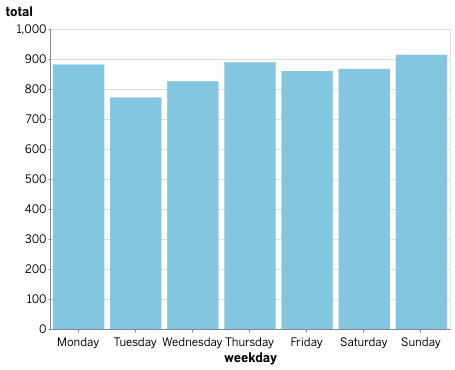

In [94]:
homeless_weekdays.head(7)
alt.Chart(homeless_weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

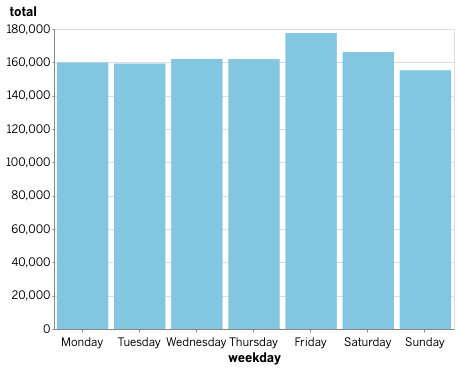

In [95]:
weekdays.head(7)
alt.Chart(weekdays).mark_bar().encode(
    x=alt.X('weekday:N', 
sort=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']),
    y='total:Q'
).properties(width=400, height=300)

---